In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\dajul\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Fully actuated Multi-rotor vehicle in SE(2)
A vehicle design for a set of $n$ rotors is the set
$$
\mathcal{D}=\{(\mathbf{p}_i, \alpha_i)| i=1,\cdots,n\}
$$
where $\mathbf{p}_i\in \mathbb{R}^2$ and $\alpha_i\in S^1$.

In [27]:
# Design: motor position and orientation (qx, qy, theta)
D = array([(0,1,0), (-cos(pi/6),-sin(pi/6),pi/2), (cos(pi/6), -sin(pi/6), -pi/2)])
D

array([[ 0.        ,  1.        ,  0.        ],
       [-0.8660254 , -0.5       ,  1.57079633],
       [ 0.8660254 , -0.5       , -1.57079633]])

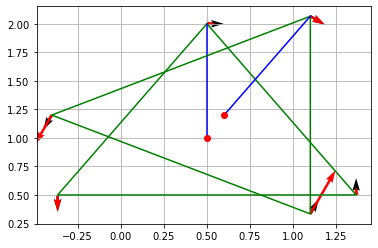

In [28]:
# The code in this cell helps to draw a vehicle. 
RotY = lambda θ: [[cos(θ), 0, sin(θ)], 
         [0, 1, 0],
         [-sin(θ), 0, cos(θ)]]

def vehicle_se2(x, z, θ, D, u=[0,0,0], ax=plt.axes()):                  
    
        
    # Design
    pxs = list(D[:,0])
    pzs = list(D[:,1])    
    αs  = copy(D[:,2])
    
    # Rotate
    R = RotY(θ)
    points = D[:,:2]
    points = array([np.dot(R, [px,0,pz]) for px,pz in points])
    pxs = points[:,0]
    pzs = points[:,2]
    αs += θ

    # Translate
    pxs += x
    pzs += z
    
    
    # propellers
    e1 = [1,0,0]    
    prop_x = array([np.dot(RotY(α), e1)[0] for α in αs])
    prop_z = array([np.dot(RotY(α), e1)[2] for α in αs])
    
    # Plot propellers
    ax.quiver(pxs, pzs, prop_x, prop_z, scale=20)
    
    # control input    
    ax.quiver(pxs, pzs, u*prop_x, u*prop_z, scale=40, color='r')
    
    # Plot Frame           
    ax.plot(list(pxs) + [pxs[0]], list(pzs) + [pzs[0]],'g')
    ax.plot([x, pxs[0]], [z, pzs[0]],'b')    
    ax.plot(x,z, 'ro')  # Center of mass
 
x, z, θ = 0.5, 1, 0
u = 1,2,1
vehicle_se2(x, z, θ, D, u)
vehicle_se2(x+0.1, z+0.2, θ+pi/6, D, u=[2,4,6])

grid()


# Design matrix
Total actuation
$$\mathbf{w}=\mathbf{A}\mathbf{u}$$

where the wrench in SE(2) is $\mathbf{w}=[f_x, f_y, \tau]^\top$. Assuming no propeller drag for the 2-D case, the design matrix is the following, 
$$
\mathbf{A} =
\begin{bmatrix}
\cos(\alpha_1) & \cos(\alpha_2) & \cos(\alpha_3)\\ 
\sin(\alpha_1) & \sin(\alpha_2) & \sin(\alpha_3) \\ 
\mathbf{p}_1\times \hat{\mathbf{f}}_1 & \mathbf{p}_2\times \hat{\mathbf{f}}_2 & \mathbf{p}_3\times \hat{\mathbf{f}}_3
\end{bmatrix}.
$$
Since $\mathbf{p}_i=[x_i,0,z_i]^\top$, and $\hat{\mathbf{f}}_i=[\cos(\alpha_i),0,\sin(\alpha_i)]^\top$, we can solve the cross product to obtain
$$
\mathbf{A} =
\begin{bmatrix}
\cos(\alpha_1) & \cos(\alpha_2) & \cos(\alpha_3)\\ 
\sin(\alpha_1) & \sin(\alpha_2) & \sin(\alpha_3) \\ 
z_1\cos(\alpha_1)-x_1\sin(\alpha_1) & z_2\cos(\alpha_2)-x_2\sin(\alpha_2) & z_3\cos(\alpha_3)-x_3\sin(\alpha_3)
\end{bmatrix}.
$$



[[ 1.00000000e+00  6.12323400e-17  6.12323400e-17]
 [ 0.00000000e+00  1.00000000e+00 -1.00000000e+00]
 [ 1.00000000e+00  8.66025404e-01  8.66025404e-01]]
Rank is 3
Eigenvalues [1.       +0.j         0.9330127+0.92819077j 0.9330127-0.92819077j]
Eigenvectors [[ 6.54653671e-01+0.00000000e+00j -4.55208892e-17+7.35561230e-17j
  -4.55208892e-17-7.35561230e-17j]
 [-7.55928946e-01+0.00000000e+00j  7.32050808e-01+0.00000000e+00j
   7.32050808e-01-0.00000000e+00j]
 [ 3.03533931e-17+0.00000000e+00j  4.90381057e-02-6.79482803e-01j
   4.90381057e-02+6.79482803e-01j]]


C:\Users\dajul\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


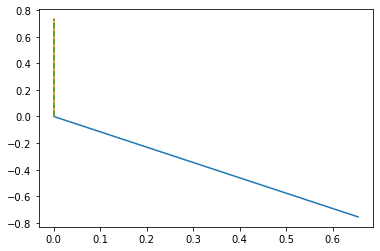

In [29]:
αs  = copy(D[:,2])
co = cos(αs)
si = sin(αs)

# Points
pxs = list(D[:,0])
pzs = list(D[:,1])

A = array([co,      si,      [pzs[0]*co[0]-pxs[0]*si[0], pzs[1]*co[1]-pxs[1]*si[1], pzs[2]*co[2]-pxs[2]*si[2]]])
print(A)
print('Rank is', np.linalg.matrix_rank(A))
eig_vals, eig_vecs = np.linalg.eig(A)
print('Eigenvalues', eig_vals)
print('Eigenvectors', eig_vecs)

e1 = eig_vecs[:,0]
e2 = eig_vecs[:,1]
e3 = eig_vecs[:,2]
# for ex,ez,eθ in eig_vecs.T[:2]:
plot([0,e1[0]],[0,e1[1]],'-')
plot([0,e2[0]],[0,e2[1]],'-')
plot([0,e3[0]],[0,e3[1]],'--')



### Euler integration

In [30]:
def simulate(Δt, x, u):
    x += Δt * u
    return x

# Simulating the multi-rotor


### Simulation parameters

In [31]:
# mass and gravity
m, g = 1, 9.8
Iy = 0.001

# z unit vector
e3 = np.array([0,0,1])
gv = [0, -g, 0] 

tf = 10.
Δt = 0.07    # Time step  ##### INCREASE THIS VALUE FOR FASTER ANIMATIONS
time = linspace(0.,tf, int(tf / Δt) + 1)  # Time interval

# Gains
kp_x, kd_x = 1, 3
kp_z, kd_z = 1, 2
kp_θ, kd_θ = 2, 4

In [32]:

# Desired state
x_d = np.array([2, 3, pi, 0., 0., 0.])

In [33]:
# Initial conditions SE x=(x, z, θ, vx, vz, vθ)
x = np.array([0, 0, 0, 0., 0., 0.])

# Inverse of the design matrix
iA = inv(A)


dx = np.zeros(6)

x_log = [copy(x)]
u_log = [[0,0,0]]

for t in time[1:]:
    px, pz, θ, vx, vz, vθ = x
    px_d, pz_d, θ_d, vx_d, vz_d, vθ_d = x_d
        
    # PD controller
    ax = kp_x * (px_d - px) + kd_x * (vx_d - vx)
    az = kp_z * (pz_d - pz) + kd_z * (vz_d - vz)
    aθ = kp_θ * (θ_d - θ)   + kd_θ * (vθ_d - vθ)
    a  = array([ax, az, aθ])  # desired acceleration
        
    
    # Control input
    B1 = [[cos(θ)/m, sin(θ)/m, 0],
         [-sin(θ)/m, cos(θ)/m, 0],
         [0, 0, 1/Iy]]
    B = np.dot(B1, A)
    iB = inv(B)
    u = np.dot(iB,(a + gv))
    
    # Saturation
#     fmax=10
#     u[u>fmax] = fmax
#     u[u<-fmax] = -fmax
        
    # Noise in the actuators
#     u += 0.01*(np.random.rand(3) - 0.5)    
#     u += np.random.normal(0, .001, 3)
    
    
    
    # Newton-Euler    
    a = np.dot(B,u) - gv      # Actual acceleration
    
    
    # Dynamics
    dx[:3] = x[3:]
    dx[3:] = a
    
    x = simulate(Δt, x, dx)
    x_log.append(copy(x))
    u_log.append(u)
    
x_log = np.array(x_log)

### Plot: time Vs z-coordinate

[]

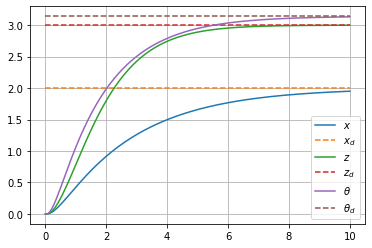

In [34]:
grid()

# X
plot(time, x_log[:,0], label='$x$')
plot(time[[0,-1]], [px_d, px_d], '--', label='$x_d$')

# Z
plot(time, x_log[:,1], label='$z$')
plot(time[[0,-1]], [pz_d, pz_d], '--', label='$z_d$')

# θ
plot(time, x_log[:,2], label='$\\theta$')
plot(time[[0,-1]], [θ_d, θ_d], '--', label='$\\theta_d$')

legend()
plot()

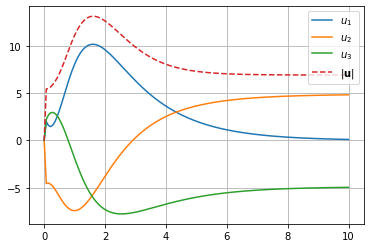

In [35]:
u_log = array(u_log)
for i in range(3):
    plot(time, u_log[:,i], label='$u_%d$'%(i+1))
plot(time, np.linalg.norm(u_log, axis=1), '--',label='$\| \mathbf{u}\|$')
grid()
legend()

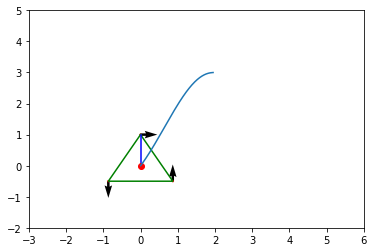

In [36]:
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display    
from IPython.display import HTML
    


fig, ax = plt.subplots()


def animate(t):
    ax.clear()
    ax.set_xlim(-3,6)
    ax.set_ylim(-2,5)
    px, pz, θ, vx, vz, vθ = x_log[t]   
    u = u_log[t]
    vehicle_se2(px, pz, θ, D, u, ax)
    
    
    # trajectory
    plot(x_log[:,0], x_log[:,1])
        

anim = animation.FuncAnimation(fig, animate, frames=len(time), interval=50)
HTML(anim.to_jshtml())

<span style="color:red; font-weight:bold">TODO: Design a multi-rotor that do not require negative forces to have full actuation</span>
